In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.express as px

In [25]:
db_filename = 'dinofunworld.db'
#conn = sqlite3.connect("./readonly/{0}".format(db_filename)) 
conn = sqlite3.connect(db_filename) 
c = conn.cursor()

In [26]:
''' Queries the database for a specific category name in category 
    table and returns {name, attractionID} from each of the rows 
    satisfying condition. categoryName is filtered using %categoryName%'''
def getRideAttractionIDsAndNames(categoryName):
    return c.execute("SELECT Name, AttractionID FROM attraction WHERE Category like '%{0}%'".format(categoryName)).fetchall()

In [27]:
''' Queries the database for name based on AttractionID in attraction'''
def getRideAttractionNames(attractionIdentifiers):
    attractionIds = list(map(str, attractionIdentifiers))
    innerQueryValue = ','.join(attractionIds)
    returnValues = c.execute("SELECT Name FROM attraction WHERE AttractionID in({0})".format(innerQueryValue)).fetchall()
    return list(map(lambda x: x[0], returnValues))

In [28]:
from enum import Enum

# to ensure that we don't check for sequences beyond 3 days.
class DaySequenceIndex(Enum):
    FirstDay=1
    SecondDay=2
    ThirdDay=3

def getAttendanceAcrossParkOnASpecificDay(sequenceString, daySequenceIndexValue):
    # considering we'll get 192 sequences of data for 16 hrs per day.
    sequencesBoundaryValue = 192
    indexValue = daySequenceIndexValue.value
    sixteenHrsSequences = sequenceString.split('-')[(indexValue-1)*sequencesBoundaryValue:(indexValue)*sequencesBoundaryValue]
    return sixteenHrsSequences

def getAttendanceAcrossParkOnAllDays(sequenceString):
    return [getAttendanceAcrossParkOnASpecificDay(sequenceString, dayIndex) for dayIndex in DaySequenceIndex]

In [29]:
def getVisitorCountToEachAttraction(attractionIds):
    attractionIdValues = list(map(int, attractionIds))
    rideCountData = {}
    defaultAttendanceForEachRide = 0
    for attractionId in attractionIdValues:
        rideCountData.setdefault(attractionId, [defaultAttendanceForEachRide for i in DaySequenceIndex])
    sequencesData = c.execute("SELECT visitorID, sequence FROM sequences").fetchall()
    sequencesDataFrame = pd.DataFrame.from_records(sequencesData, columns=['visitorID','sequence'])
    for individualSequenceData in sequencesDataFrame['sequence']:
        allDaysAttendanceForThisVisitor = getAttendanceAcrossParkOnAllDays(individualSequenceData)
        for loopIndex,individualDayAttendance in enumerate(allDaysAttendanceForThisVisitor):
            for everyFiveMinutesAttractionIdValue in individualDayAttendance:
                attractionIntegerValue = int(everyFiveMinutesAttractionIdValue)
                if attractionIntegerValue in attractionIdValues:
                    existingRideCountDataValue = rideCountData[attractionIntegerValue][loopIndex]
                    rideCountData[attractionIntegerValue][loopIndex] = existingRideCountDataValue+1
    return rideCountData

    Minimum Attendance  Average Attendance  Maximum Attendance
1                 7122               13059        10128.000000
2                 7993               14385        10874.333333
3                 7146               50545        22844.000000
4                30961               56120        47634.000000
5                10141               64747        44868.000000
6                 8432               16547        12364.333333
7                10358               65336        44826.000000
8                14571               31207        24261.000000
9                 5501               12011         8653.333333
10                2824                5264         4160.333333
11                2358                6956         4582.333333
12                2262                4822         3794.333333
13                1734                3461         2486.000000
14                1735                3651         2663.000000
15                1692                2956         2470

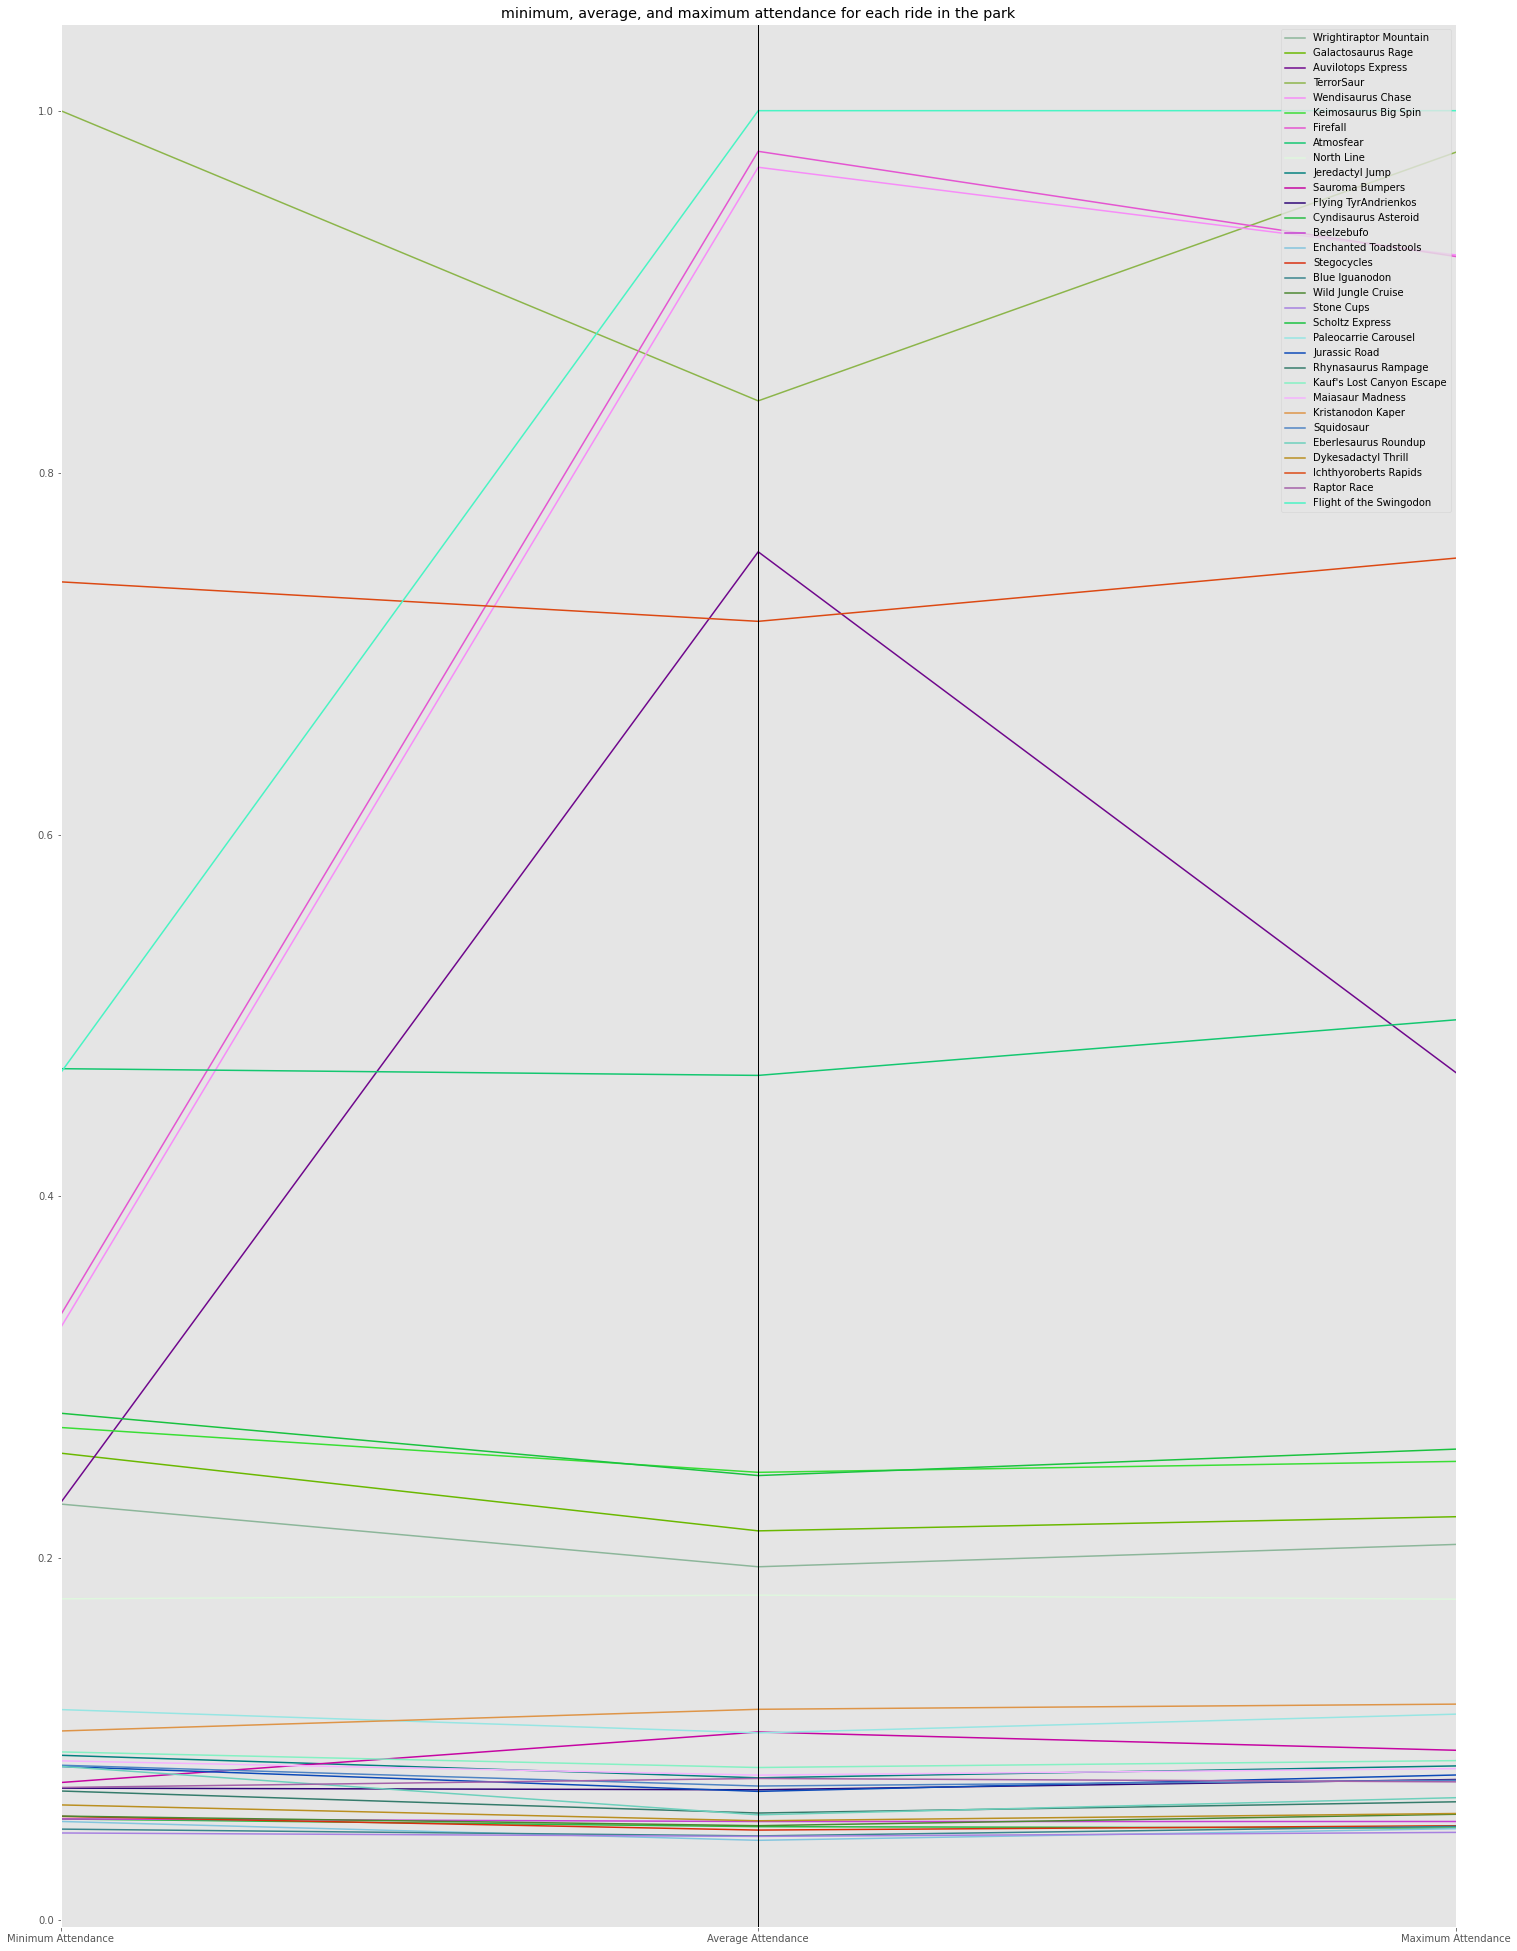

In [42]:
# Graded Cell, PartID: 8S2jm
# Create and display a Parallel Coordinate Plot displaying the minimum, average, 
# and maximum attendance for each ride in the park (note that not all attractions
# are rides).
#Average attendance is total attendance of the ride/number of rides.
attractionDetailsDataFrame = pd.DataFrame.from_records(getRideAttractionIDsAndNames('Ride'), columns = ['RideName','AttractionID'])
visitorCountAcrossDaysForEachAttraction = getVisitorCountToEachAttraction(attractionDetailsDataFrame['AttractionID'])

convertedDataDictionaryForDataFrame = {}
for attractionId,visitorCount in visitorCountAcrossDaysForEachAttraction.items():
    convertedDataDictionaryForDataFrame[attractionId] = [min(visitorCount), max(visitorCount), sum(visitorCount)/len(visitorCount)]

columnNames = ['Minimum Attendance','Average Attendance', 'Maximum Attendance']
dataFrameForPlot = pd.DataFrame(convertedDataDictionaryForDataFrame.values(),columns=columnNames,index=convertedDataDictionaryForDataFrame.keys()).sort_index()
print(dataFrameForPlot)
dataFramePlotCopy = dataFrameForPlot.copy()

dataFramePlotCopy['Minimum Attendance'] = dataFramePlotCopy['Minimum Attendance'] /dataFramePlotCopy['Minimum Attendance'].abs().max()
dataFramePlotCopy['Average Attendance'] = dataFramePlotCopy['Average Attendance'] /dataFramePlotCopy['Average Attendance'].abs().max()
dataFramePlotCopy['Maximum Attendance'] = dataFramePlotCopy['Maximum Attendance'] /dataFramePlotCopy['Maximum Attendance'].abs().max()

dataFramePlotCopy['AttractionName'] = getRideAttractionNames(convertedDataDictionaryForDataFrame.keys())
dataFramePlotCopy.set_index('AttractionName')

# scaledData = MinMaxScaler().fit_transform(dataFrameForPlot)
# scaled_df = pd.DataFrame(data=scaledData,columns=columnNames)
# scaled_df['AttractionName'] = getRideAttractionNames(convertedDataDictionaryForDataFrame.keys())
# scaled_df.set_index('AttractionName')

with plt.style.context(("ggplot")):
    fig = plt.figure(figsize=(25,35))
    pd.plotting.parallel_coordinates(dataFramePlotCopy, "AttractionName")
    plt.title("minimum, average, and maximum attendance for each ride in the park")
    
# df_max_scaled = dataFrameForPlot.copy()
  
# # apply normalization techniques on Column 1
# column = 'Minimum Attendance'
# df_max_scaled[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()
  
# # view normalized data
# display(df_max_scaled)

ValueError: too many values to unpack (expected 3)

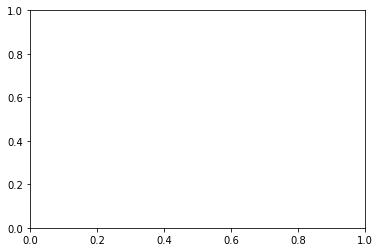

In [46]:
g1 = dataFramePlotCopy['Minimum Attendance']
g2 = dataFramePlotCopy['Average Attendance']
g3 = dataFramePlotCopy['Maximum Attendance']

data = (g1, g2, g3)
colors = ("red", "green", "blue")
groups = ("coffee", "tea", "water")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    x,y,z = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Matplot scatter plot')
plt.legend(loc=2)
plt.show()